In [1]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

if IS_COLAB:
    !git clone https://github.com/Merijn68/BondTrading.git    
    %pip install -q "ray[tune]" bayesian-optimization
    %pip install loguru tensorflow-addons

# Base model

In eerste instantie wordt een naive voorspelling gemaakt voor de bond markt. Het doel hiervan is om een benchmark te hebben waarmee de andere modellen kunnen worden vergeleken. We voorspellen voor 1 bond voor 10 dagen vooruit wat de bond prijs gaat doen. Idealiter zouden we de prijsontwikkeling van meerdere (alle) staatsobligaties tegelijk willen voorspellen, zodat het model op 1 moment kan aangeven welke bond een betere investering zou zijn. Maar 1 stap tegelijk.

In [2]:
%load_ext autoreload
%autoreload 2

import sys
import math
import matplotlib.pyplot as plt
sys.path.insert(0, "..")
from src.data import make_dataset
from src.models import window, evaluate, base_model
from pathlib import Path
datadir = Path("../data/raw")

import tensorflow as tf
import numpy as np

In [3]:
df_price = make_dataset.read_pkl('price')
isin = "DE0001102374" # 10 Years NL Bond, maturity 2025 0.5% coupon
df_isin = df_price[df_price['reference_identifier'] == isin]
df_isin = df_isin.set_index('rate_dt')
df_isin = df_isin.sort_index()

2022-01-14 16:15:05.209 | INFO     | src.data.make_dataset:read_pkl:377 - Load preprocessed price data


<AxesSubplot:xlabel='rate_dt'>

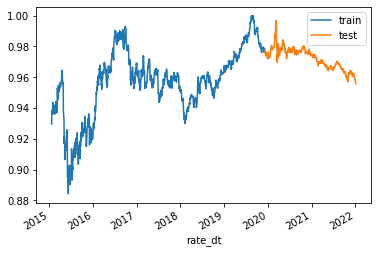

In [4]:
series = df_isin['mid']
split = math.floor(len(series) * .70)

# Train test split
train = series[:split]
norm = max(train)
test = series[split:]
train = train / norm
test = test / norm
train.plot(label = "train",legend=True)
test.plot(label ="test",legend=True)

In [5]:
(train.shape, test.shape)

((1245,), (534,))

In [6]:
# Create a windowed dataset from the data
window_size = 32 
batch_size = 32
shuffle_buffer = 2
horizon = 10
train_set = window.windowed_dataset(train, window_size, batch_size, shuffle_buffer, horizon=horizon)
valid_set = window.windowed_dataset(test, window_size, batch_size, shuffle_buffer, horizon=horizon)

In [7]:
x, y = next(iter(train_set))
x.shape, y.shape

(TensorShape([32, 32]), TensorShape([32, 10]))

In [8]:
# This needs to move somewhere else...

maelist = []
for x, y in train_set:      
    x = x[:, -1] # get the last value of every batch
    size = tf.size(x) # this will be the batchsize, so mostly 32
    yhat = tf.broadcast_to(tf.reshape(x, [size,1]), [size, horizon]) # broadcast
    mae = np.mean(np.abs(yhat - y)) # calculate mae
    maelist.append(mae)
norm = np.mean(maelist)
print(norm)
smae = evaluate.ScaledMAE(scale=norm)


0.00407483552631579


In [9]:
# 1 step naive prediction
y, yhat = base_model.naivepredict(train.values)
norm = evaluate.mae(y, yhat)
norm, evaluate.mse(y, yhat), evaluate.mase(y, yhat)

(0.0017166150484410488, 6.262746686111532e-06, 1.003087633997175)

Een eenvoudig referentie model

In [10]:
%load_ext tensorboard

In [11]:
result = {}

In [12]:
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as tfl
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

model = Sequential([    
        tfl.Reshape((window_size, 1)),
        tfl.SimpleRNN(1),
        tfl.Dense(horizon)
    ])
early_stop = EarlyStopping(patience=10, restore_best_weights=True)


In [13]:

for lr in [1e-2, 1e-3, 1e-4]:
    name = f"simpleRNN_Adam{lr}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)    
    model.compile(loss="mse", optimizer=Adam(learning_rate=lr), metrics=["mae", smae])
    result[name] = model.fit(train_set,epochs=200, validation_data=valid_set, callbacks=[early_stop, tb], verbose=0)
    print('lr:', lr, model.evaluate(valid_set))

16/16 [==============================] - 0s 15ms/step - loss: 3.1021e-05 - mae: 0.0046 - smae: 1.1282
lr: 0.01 [3.102124173892662e-05, 0.004597429186105728, 1.1282490491867065]
16/16 [==============================] - 1s 29ms/step - loss: 6.8155e-05 - mae: 0.0067 - smae: 1.6470
lr: 0.001 [6.815462256781757e-05, 0.0067113894037902355, 1.6470333337783813]
16/16 [==============================] - 0s 18ms/step - loss: 1.0751e-04 - mae: 0.0089 - smae: 2.1882
lr: 0.0001 [0.00010750814544735476, 0.008916357532143593, 2.1881511211395264]


In [14]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 17560), started 3:13:47 ago. (Use '!kill 17560' to kill it.)

Het blijkt moeilijk om de naive voorspelling te verbeteren. Een hogere learning rate is zeker in het begin nodig. Na max 10 epochs is het model dan ook wel uitgeleerd en kunnen we waarschijnlijk beter met een lagere learning rate verder gaan.

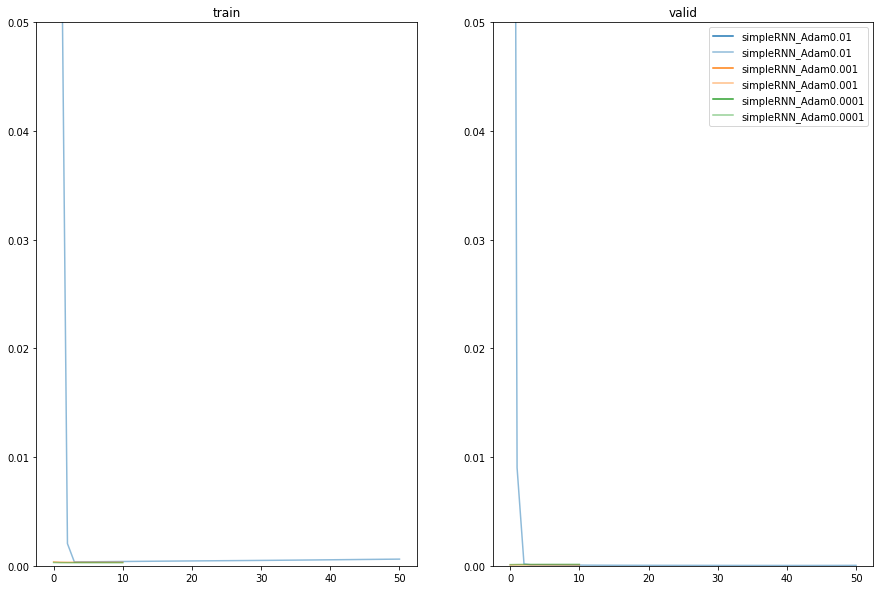

In [15]:
from src.models import evaluate
evaluate.plot_results(result, ymax = 0.05, subset="simple")

In [16]:
result.keys()

dict_keys(['simpleRNN_Adam0.01', 'simpleRNN_Adam0.001', 'simpleRNN_Adam0.0001'])

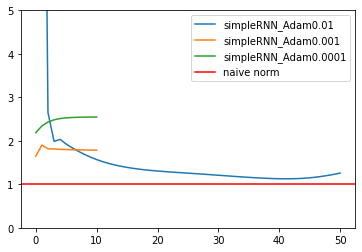

In [17]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="simple")

In [18]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

name = f"simpleRNN_Adam_rlr"
logdir = Path("logs") / name
tb = TensorBoard(logdir, histogram_freq=1)
lr = 0.01

reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=3, min_lr=1e-5)
model.compile(loss="mse", optimizer=Adam(learning_rate = lr), metrics=["mae", smae])                              
result[name] = model.fit(train_set, epochs=200, validation_data=valid_set, callbacks=[reduce_lr, early_stop, tb], verbose=0)

Ook wanneer we de learning rate reduceren wordt het model niet veek beter. Na 7 epochs is het resultaat wel beter dan het naive model.

Uitbreiden van het model

In [19]:
opt = tf.keras.optimizers.get('Adam')
opt.learning_rate = 0.1
opt.get_config()

{'name': 'Adam',
 'learning_rate': 0.1,
 'decay': 0.0,
 'beta_1': 0.9,
 'beta_2': 0.999,
 'epsilon': 1e-07,
 'amsgrad': False}

In [20]:
from src.models import hyper
from tqdm import tqdm

config = {
    'window'    :   32,
    'filters'   :   16,
    'kernel'    :   4,    
    'units'     :   16,    
    'hidden'    :   1, 
    'horizon'   :   horizon,
    'type'      :   'RNN'    
}

for key in tqdm(["Adam", "SGD", "RMSprop"]):
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    name = f"16_RNN_{key}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)
    
    opt = tf.keras.optimizers.get(key)
    opt.momentum = 0.9
    opt.learning_rate = 0.01

    model = hyper.HyperRnn(config)
    model.compile(loss="mse",
          optimizer=opt,
          metrics=["mae", "mape", smae])

    result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                            validation_data=valid_set, verbose=0)
    print('opt:', key, model.evaluate(valid_set))

  0%|          | 0/3 [00:00<?, ?it/s]

16/16 [==============================] - 0s 19ms/step - loss: 6.3039e-05 - mae: 0.0065 - mape: 0.6703 - smae: 1.6032


 33%|███▎      | 1/3 [03:02<06:04, 182.44s/it]

opt: Adam [6.303933332674205e-05, 0.0065329414792358875, 0.6703067421913147, 1.603240728378296]
16/16 [==============================] - 0s 23ms/step - loss: 1.2532e-04 - mae: 0.0088 - mape: 0.9032 - smae: 2.1624


 67%|██████▋   | 2/3 [18:14<10:11, 611.52s/it]

opt: SGD [0.00012532004620879889, 0.008811268955469131, 0.9031656384468079, 2.1623616218566895]
16/16 [==============================] - 0s 17ms/step - loss: 5.0683e-05 - mae: 0.0060 - mape: 0.6205 - smae: 1.4825


100%|██████████| 3/3 [22:32<00:00, 450.70s/it]

opt: RMSprop [5.068312384537421e-05, 0.006041141226887703, 0.6204524040222168, 1.482548475265503]


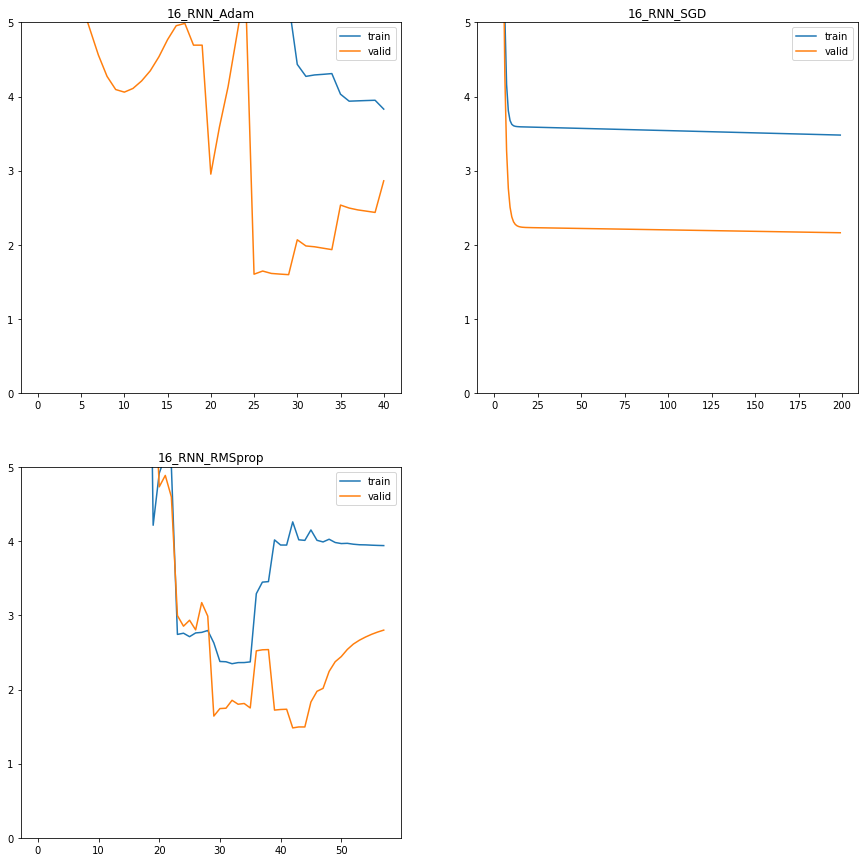

In [21]:
evaluate.plot_results(result, ymax = 5, subset="16",grid = True, measure = 'smae')

Het wordt er niet beter op. RMSprop lijkt iets beter te leren. Opvallend verder dat de modellen het allemaal beter doen op de validatie set dan op de training set.

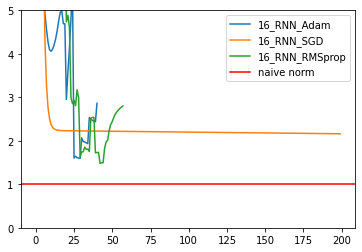

In [22]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=5.0, subset="16")

Deeper models with memory...

In [23]:
reduce_lr = ReduceLROnPlateau(monitor='smae', factor=0.5,
                              patience=3, min_lr=1e-5)

config = {
    "window" : window_size,
    "filters" : 64,
    "kernel" : 3,
    "type" : "GRU",
    "units" : 128,
    "hidden" : 4,
    "horizon" : horizon,
}

for key in tqdm(["Adam", "SGD", "RMSprop"]):
    early_stop = EarlyStopping(patience=15, restore_best_weights=True)

    name = f"GRU_{key}"
    logdir = Path("logs") / name
    tb = TensorBoard(logdir, histogram_freq=1)

    opt = tf.keras.optimizers.get(key)
    opt.momentum = 0.9
    opt.learning_rate = 0.01

    model = hyper.HyperRnn(config)
    model.compile(loss="mse",
          optimizer=opt,
          metrics=["mae", "mape", smae])
    
    result[name] = model.fit(train_set,epochs=200,callbacks=[tb, early_stop, reduce_lr],
                            validation_data=valid_set, verbose=0)
    print('opt:', key, model.evaluate(valid_set))

  0%|          | 0/3 [00:00<?, ?it/s]

16/16 [==============================] - 0s 18ms/step - loss: 1.9435e-05 - mae: 0.0034 - mape: 0.3515 - smae: 0.8388


 33%|███▎      | 1/3 [00:17<00:34, 17.42s/it]

opt: Adam [1.943487222888507e-05, 0.003417982254177332, 0.3514636158943176, 0.8388026356697083]
16/16 [==============================] - 0s 10ms/step - loss: 2.7641e-05 - mae: 0.0041 - mape: 0.4243 - smae: 1.0168


 67%|██████▋   | 2/3 [02:42<01:32, 92.72s/it]

opt: SGD [2.7640660846373066e-05, 0.004143249709159136, 0.4243396520614624, 1.016789436340332]
16/16 [==============================] - 0s 13ms/step - loss: 4.8055e-05 - mae: 0.0056 - mape: 0.5801 - smae: 1.3803


100%|██████████| 3/3 [03:24<00:00, 68.29s/it]

opt: RMSprop [4.805513526662253e-05, 0.005624391138553619, 0.5801055431365967, 1.3802744150161743]


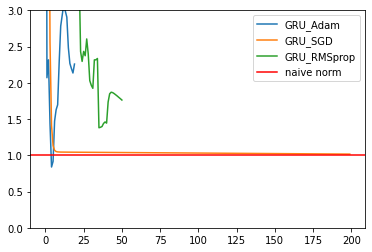

In [24]:
plt.figsize=(8,12)
evaluate.naive(result, ylim=3.0, subset="GRU")

Modellen met historie doen het aanzienlijk beter - zoals verwacht. De RMSprop optimizer lijkt het nu juist weer een stuk minder goed te doen.

In [25]:
# Hypertune

from ray import tune
config = {
    "datadir" : Path("data").absolute(),
    "grace_period" : 3,
    "local_dir" : "logs",
    "epochs" : 20,
    "samples" : 25,
    "window" : tune.randint(16, 52),
    "filters" : tune.randint(8, 32),
    "kernel" : 3,
    "type" : tune.choice(["GRU", "LSTM"]),
    "optimizer" : tune.choice(["Adam", "RMSprop"]),
    "hidden" : tune.randint(1, 5),
    "units" : tune.qrandint(64, 256, 16),
    "horizon" : 10,
}

In [26]:
analysis = hyper.hypertune(config)

Trial name,status,loc,filters,hidden,optimizer,type,units,window
wrapper_290ff_00006,RUNNING,127.0.0.1:10664,17,4,RMSprop,GRU,128,35
wrapper_290ff_00007,PENDING,,18,2,Adam,GRU,64,45
wrapper_290ff_00008,PENDING,,29,1,RMSprop,GRU,112,16
wrapper_290ff_00009,PENDING,,15,1,Adam,LSTM,144,18
wrapper_290ff_00010,PENDING,,24,1,Adam,GRU,240,49
wrapper_290ff_00011,PENDING,,9,2,Adam,GRU,144,26
wrapper_290ff_00012,PENDING,,24,3,Adam,GRU,208,16
wrapper_290ff_00013,PENDING,,15,2,Adam,GRU,208,33
wrapper_290ff_00014,PENDING,,18,3,RMSprop,LSTM,224,23
wrapper_290ff_00015,PENDING,,29,1,Adam,LSTM,96,47


 pid=10664) 2022-01-14 16:46:49,016	ERROR function_runner.py:268 -- Runner Thread raised error.
 pid=10664) Traceback (most recent call last):
 pid=10664)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 262, in run
 pid=10664)     self._entrypoint()
 pid=10664)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 330, in entrypoint
 pid=10664)     return self._trainable_func(self.config, self._status_reporter,
 pid=10664)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
 pid=10664)     return method(self, *_args, **_kwargs)
 pid=10664)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 597, in _trainable_f

Result for wrapper_290ff_00006:
  date: 2022-01-14_16-46-49
  experiment_id: 6820819362cf4860a196d7c1e8981dc9
  hostname: Game-PC
  node_ip: 127.0.0.1
  pid: 10664
  timestamp: 1642175209
  trial_id: 290ff_00006
  


 pid=1592) 2022-01-14 16:46:50,373	ERROR function_runner.py:268 -- Runner Thread raised error.
 pid=1592) Traceback (most recent call last):
 pid=1592)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 262, in run
 pid=1592)     self._entrypoint()
 pid=1592)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 330, in entrypoint
 pid=1592)     return self._trainable_func(self.config, self._status_reporter,
 pid=1592)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\util\tracing\tracing_helper.py", line 451, in _resume_span
 pid=1592)     return method(self, *_args, **_kwargs)
 pid=1592)   File "C:\Users\M\AppData\Local\pypoetry\Cache\virtualenvs\bondtrading-jbUXhQqa-py3.9\lib\site-packages\ray\tune\function_runner.py", line 597, in _trainable_func
 pid=

Result for wrapper_290ff_00007:
  date: 2022-01-14_16-46-50
  experiment_id: 45b11906ffcb40b6bde185aaa3a460ef
  hostname: Game-PC
  node_ip: 127.0.0.1
  pid: 1592
  timestamp: 1642175210
  trial_id: 290ff_00007
  


2022-01-14 17:00:54,722	WARNING tune.py:582 -- SIGINT received (e.g. via Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C one more time (or send SIGINT/SIGKILL/SIGTERM) to skip. 


In [ ]:
config = analysis.get_best_config()
config

In [ ]:
window_size = config["window"]
horizon = config["horizon"]
train_set = make_dataset.windowed_dataset(
    train, window_size, batch_size=32, shuffle_buffer=25, horizon=horizon
)
valid_set = make_dataset.windowed_dataset(
    train, window_size, batch_size=32, shuffle_buffer=25, horizon=horizon
)

In [ ]:
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5
)
opt = tf.keras.optimizers.get(config["optimizer"])
opt.momentum = 0.9
opt.learning_rate = 0.01
model = hyper.HyperRnn(config)
model.compile(loss="mse", optimizer=opt, metrics=["mae", "mape", smae])

result["hypertuned"] = model.fit(
        train_set,
        epochs=150,
        validation_data=valid_set,
        callbacks=[reduce_lr, early_stop],
    )


In [ ]:
plt.figure(figsize=(8,8))
evaluate.naive(result, ylim=1.5)

In [ ]:
evaluate.plot_results(result, ymax = 0.1)

In [ ]:
pred = evaluate.generate_prediction(model, test, window = window_size, horizon = horizon)

In [ ]:
pred = evaluate.generate_prediction(model, test, window = window_size, horizon = 4)